In [41]:
import fiona
import math
import json
import uuid
from fiona.crs import from_epsg
from shapely.geometry import shape, MultiPolygon
from shapely.ops import transform, unary_union
import pyproj

## Private ownership

Merge features that share the same owner

In [ ]:
with fiona.open('sources/private-industrial-ownership-wgs84.gpkg', 'r') as src:
    private_industrial = [feature for feature in src]
    
    for feature in private_industrial: 
        if feature['properties']['LandManager'] == 'PVI':
            feature['properties'] = {'owner': feature['properties']['Owner'], 'owner_class': 'private_industrial'}
        else: 
            feature['properties'] = {'owner': 'Private Non-Industrial', 'owner_class': 'private_non_industrial'}
            
    grouped_features = {}
    # combine the features that have the same owner into a single multipolygon
    for feature in private_industrial:
        if feature['properties']['owner'] not in grouped_features:
            grouped_features[feature['properties']['owner']] = feature
        else:
            geometry = shape(feature['geometry'])
            geometry2 = shape(grouped_features[feature['properties']['owner']]['geometry'])
            combined_geometry = unary_union([geometry, geometry2])
            assert type(combined_geometry) == MultiPolygon
            grouped_features[feature['properties']['owner']] = {'geometry': combined_geometry, 'properties': feature['properties']}

Now we add an ID, calculate the area in acres by converting to Oregon Lambert, and calclate the percent of the class each feature represents.

In [ ]:
total_industrial_area = 0
total_non_industrial_area = 0    

for feature in grouped_features.values():
    
    # add a unique id to each feature
    feature['id'] = uuid.uuid4().int % (10**10)
    
    geometry = shape(feature['geometry'])
    # Project from WGS84 (EPSG:4326) to Oregon Lambert (EPSG:2992)
    transformer = pyproj.Transformer.from_crs('EPSG:4326', 'EPSG:2992', always_xy=True)
    projected = transform(transformer.transform, geometry)
    # oregon lambert is in square feet, convert to acres (1 acre = 43,560 square feet)
    feature['properties']['area'] = round(shapely.area(projected) / 43560)
    
    # calculate the total area of each class
    if feature['properties']['owner_class'] == 'private_industrial':
        total_industrial_area += feature['properties']['area']
    else:
        total_non_industrial_area += feature['properties']['area']
        
# add the percent of each class each feature represents
for feature in grouped_features.values():
    if feature['properties']['owner_class'] == 'private_industrial':
        feature['properties']['percent_of_class'] = round(feature['properties']['area'] / total_industrial_area * 100, 2)
    else:
        feature['properties']['percent_of_class'] = round(feature['properties']['area'] / total_non_industrial_area * 100, 2)
        
    feature['properties']['name'] = feature['properties']['owner']
        
        
# print total acres and percent for each feature
for feature in grouped_features.values():
    print(feature['properties']['owner'], feature['properties']['area'], feature['properties']['percent_of_class'])

print(total_industrial_area)
print(total_non_industrial_area)


In [ ]:
schema = {
    'geometry': 'MultiPolygon',
    'id': 'int',
    'properties': {
        'owner': 'str',
        'owner_class': 'str',
        'name': 'str',
        'area': 'int',
        'percent_of_class': 'float'
    }
}

with fiona.open('sources/clean-private-lands.gpkg', 'w', driver='GPKG', schema=schema, crs=from_epsg(4326)) as dst:
    dst.writerecords(grouped_features.values())

Create a summary statistics file

In [ ]:
out_json = {
    'industrial_owners': [],
    'non_industrial_owners': [],
    'total_industrial_acres': total_industrial_area,
    'total_non_industrial_acres': total_non_industrial_area
}

# sort the features by area in descending order
grouped_features_sorted = sorted(grouped_features.values(), key=lambda x: x['properties']['area'], reverse=True)

# add the features to the out_json
for feature in grouped_features_sorted:
    if feature['properties']['owner_class'] == 'private_industrial':
        out_json['industrial_owners'].append({'owner': feature['properties']['owner'], 'acres': feature['properties']['area'], 'percent_of_class': feature['properties']['percent_of_class'], 'id': feature['id']})
    else:
        out_json['non_industrial_owners'].append({'owner': feature['properties']['owner'], 'acres': feature['properties']['area'], 'percent_of_class': feature['properties']['percent_of_class'], 'id': feature['id']})

# save the out_json to a json file
with open('summary/private-ownership.json', 'w') as f:
    json.dump(out_json, f)


# State lands

Merge ODF/state land board owned lands 

In [ ]:
def get_area_acres(geometry):
    transformer = pyproj.Transformer.from_crs('EPSG:4326', 'EPSG:2992', always_xy=True)
    projected = transform(transformer.transform, geometry)
    return round(shapely.area(projected) / 43560)

with fiona.open('sources/ODF-lands.gpkg', 'r', layer='bounds') as src:
    odf_lands = [feature for feature in src]
    geometries = []
    for feature in odf_lands:
        geometry = shape(feature['geometry'])
        geometries.append(geometry)
    odf_lands_feature = {'geometry': unary_union(geometries)}
    odf_lands_feature['properties'] = {'owner': 'Oregon Department of Forestry', 'owner_class': 'state', 'area': get_area_acres(odf_lands_feature['geometry']), 'percent_of_class': 100, 'name': 'Oregon Department of Forestry'}
    odf_lands_feature['id'] = uuid.uuid4().int % (10**10)
    
with fiona.open('sources/oregon-state-land-board.gpkg', 'r', layer='bounds') as src:
    oslb_lands = [feature for feature in src]
    geometries = []
    for feature in oslb_lands:
        geometry = shape(feature['geometry'])
        geometries.append(geometry)
    oslb_lands_feature = {'geometry': unary_union(geometries)}
    oslb_lands_feature['properties'] = {'owner': 'Oregon State Land Board', 'owner_class': 'state', 'area': get_area_acres(oslb_lands_feature['geometry']), 'percent_of_class': 100, 'name': 'Oregon State Land Board'}
    oslb_lands_feature['id'] = uuid.uuid4().int % (10**10)

schema = {
    'geometry': 'MultiPolygon',
    'id': 'int',
    'properties': {
        'owner': 'str',
        'owner_class': 'str',
        'area': 'int',
        'percent_of_class': 'float',
        'name': 'str'
    }
}   

with fiona.open('sources/clean-state-lands.gpkg', 'w', driver='GPKG', schema=schema, crs=from_epsg(4326)) as dst:
    # add the odf_lands_feature and oslb_lands_feature to the dst
    dst.write(odf_lands_feature)
    dst.write(oslb_lands_feature)




## National forests 

Clean up the national forest features

In [ ]:
with fiona.open('sources/usfs-oregon.gpkg', 'r', layer='bounds') as src:
    forest_lands = [feature for feature in src]

    total_forest_area = 0
    for feature in forest_lands:
        area = get_area_acres(shape(feature['geometry']))  
        total_forest_area += area
        feature['properties'] = {'owner': 'United States Forest Service', 'owner_class': 'federal', 'area': area, 'percent_of_class': 0, 'name': feature['properties']['FORESTNAME']}
        feature['id'] = uuid.uuid4().int % (10**10)
        
    for feature in forest_lands:
        feature['properties']['percent_of_class'] = round(feature['properties']['area'] / total_forest_area * 100, 2)
        
        
    schema = {
        'geometry': 'MultiPolygon',
        'id': 'int',
        'properties': {
            'owner': 'str',
            'owner_class': 'str',
            'area': 'int',          
            'percent_of_class': 'float',
            'name': 'str'
        }
    }
    
    with fiona.open('sources/clean-usfs-lands.gpkg', 'w', driver='GPKG', schema=schema, crs=from_epsg(4326)) as dst:
        dst.writerecords(forest_lands)

/var/folders/8h/kk4k5t952ydbc8hfg6nct2940000gn/T/ipykernel_38736/4215322853.py:8: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  feature['properties'] = {'owner': 'United States Forest Service', 'owner_class': 'federal', 'area': area, 'percent_of_class': 0, 'name': feature['properties']['FORESTNAME']}
/var/folders/8h/kk4k5t952ydbc8hfg6nct2940000gn/T/ipykernel_38736/4215322853.py:9: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  feature['id'] = uuid.uuid4().int % (10**10)


## BLM lands 

Clean up BLM features

In [60]:
with fiona.open('sources/blm-all-lands.gpkg', 'r', layer='bounds') as src:
    blm_lands = [feature for feature in src]

    for feature in blm_lands:
        if feature['properties']['FeeTitleHolder'] == 'USDI Bureau of Land Management O&C Lands':
            name = 'Bureau of Land Management O&C Lands'
        else: 
            name = "Bureau of Land Management"
        feature['properties'] = {'owner': 'Bureau of Land Management', 'owner_class': 'federal', 'area': 0, 'percent_of_class': 0, 'name': name}
        
    # merge all features with the same name into a single feature
    grouped_blm_lands = {}
    for feature in blm_lands:
        if feature['properties']['name'] not in grouped_blm_lands:
            grouped_blm_lands[feature['properties']['name']] = feature
        else:
            geometry = shape(feature['geometry'])
            geometry2 = shape(grouped_blm_lands[feature['properties']['name']]['geometry'])
            combined_geometry = unary_union([geometry, geometry2])
            grouped_blm_lands[feature['properties']['name']] = {'geometry': combined_geometry, 'properties': feature['properties']}
            
    total_blm_area = 0
    # calculate the area of each feature
    for feature in grouped_blm_lands.values():
        feature['properties']['area'] = get_area_acres(shape(feature['geometry']))
        total_blm_area += feature['properties']['area']
        
    # add the percent of each feature
    for feature in grouped_blm_lands.values():
        feature['properties']['percent_of_class'] = round(feature['properties']['area'] / total_blm_area * 100, 2)
        
    schema = {
        'geometry': 'MultiPolygon',
        'id': 'int',
        'properties': {
            'owner': 'str',
            'owner_class': 'str',
            'area': 'int',
            'percent_of_class': 'float',
            'name': 'str'
        }
    }
   
    # save the grouped_blm_lands to a gpkg file
    with fiona.open('sources/clean-blm-lands.gpkg', 'w', driver='GPKG', schema=schema, crs=from_epsg(4326)) as dst:
        dst.writerecords(grouped_blm_lands.values())


/var/folders/8h/kk4k5t952ydbc8hfg6nct2940000gn/T/ipykernel_38736/1811175559.py:9: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  feature['properties'] = {'owner': 'Bureau of Land Management', 'owner_class': 'federal', 'area': 0, 'percent_of_class': 0, 'name': name}


In [61]:

    
with fiona.open('sources/usfs-timber-harvests.gpkg', 'r') as src:
    harvests = [feature for feature in src]
    
#group each feature by ADMIN_FOREST_NAME 
grouped_harvests = {}
for feature in harvests:
    forest_name = feature['properties']['ADMIN_FOREST_NAME']
    if forest_name not in grouped_harvests:
        grouped_harvests[forest_name] = [feature]
    else:
        grouped_harvests[forest_name].append(feature)

ModuleNotFoundError: No module named 'matplotlib'

In [67]:
activities = {}

for feature in harvests: 
    activity = feature['properties']['ACTIVITY_NAME'] 
    if activity is not None: 
        if activity not in activities:
            activities[activity] = 1
        else: 
            activities[activity] += 1
            
            
# Print counts for all timber harvest activities
print("\nTimber harvest activity counts:")
for activity, count in sorted(activities.items()):
    print(f"{activity}: {count}")



Timber harvest activity counts:
Administrative Changes: 1
Commercial Thin: 25502
Group Selection Cut (UA/RH/FH): 883
Harvest Without Restocking: 43
Improvement Cut: 3622
Liberation Cut: 32
Natural Changes (excludes fire): 723
Overstory Removal Cut (from advanced regeneration) (EA/RH/FH): 8215
Patch Clearcut (EA/RH/FH): 2190
Patch Clearcut (w/ leave trees) (EA/RH/FH): 2056
Permanent Land Clearing: 46
Salvage Cut (intermediate treatment, not regeneration): 7840
Sanitation Cut: 2799
Seed-tree Final Cut (EA/NRH/FH): 463
Seed-tree Preparatory Cut (EA/NRH/NFH): 75
Seed-tree Removal Cut (w/ leave trees) (EA/NRH/FH): 53
Seed-tree Seed Cut (with and without leave trees) (EA/RH/NFH): 4389
Shelterwood Establishment Cut (with or without leave trees) (EA/RH/NFH): 6349
Shelterwood Preparatory Cut (EA/NRH/NFH): 1042
Shelterwood Removal Cut (EA/NRH/FH): 4422
Shelterwood Removal Cut (w/ leave trees) (EA/NRH/FH): 202
Shelterwood Staged Removal Cut (EA/NRH/NFH): 103
Single-tree Selection Cut (UA/RH/FH):

In [68]:
# Find most recent OBJECTID for each activity type
most_recent_by_activity = {}

for feature in harvests:
    activity = feature['properties']['ACTIVITY_NAME']
    year = feature['properties']['FY_COMPLETED']
    obj_id = feature['properties']['OBJECTID']
    
    if activity is not None and year is not None:
        if activity not in most_recent_by_activity:
            most_recent_by_activity[activity] = (year, obj_id)
        else:
            if year > most_recent_by_activity[activity][0]:
                most_recent_by_activity[activity] = (year, obj_id)

print("\nMost recent OBJECTID for each activity type:")
for activity, (year, obj_id) in sorted(most_recent_by_activity.items()):
    print(f"{activity}: OBJECTID {obj_id} (FY {year})")



Most recent OBJECTID for each activity type:
Administrative Changes: OBJECTID 525033 (FY 1966)
Commercial Thin: OBJECTID 19135 (FY 2025)
Group Selection Cut (UA/RH/FH): OBJECTID 500979 (FY 2024)
Harvest Without Restocking: OBJECTID 346913 (FY 2020)
Improvement Cut: OBJECTID 141715 (FY 2025)
Liberation Cut: OBJECTID 27547 (FY 2020)
Natural Changes (excludes fire): OBJECTID 553081 (FY 2004)
Overstory Removal Cut (from advanced regeneration) (EA/RH/FH): OBJECTID 378197 (FY 2025)
Patch Clearcut (EA/RH/FH): OBJECTID 791819 (FY 2023)
Patch Clearcut (w/ leave trees) (EA/RH/FH): OBJECTID 454185 (FY 2017)
Permanent Land Clearing: OBJECTID 380323 (FY 2023)
Salvage Cut (intermediate treatment, not regeneration): OBJECTID 378637 (FY 2025)
Sanitation Cut: OBJECTID 629746 (FY 2023)
Seed-tree Final Cut (EA/NRH/FH): OBJECTID 115728 (FY 2020)
Seed-tree Preparatory Cut (EA/NRH/NFH): OBJECTID 508428 (FY 2011)
Seed-tree Removal Cut (w/ leave trees) (EA/NRH/FH): OBJECTID 481719 (FY 2018)
Seed-tree Seed Cu

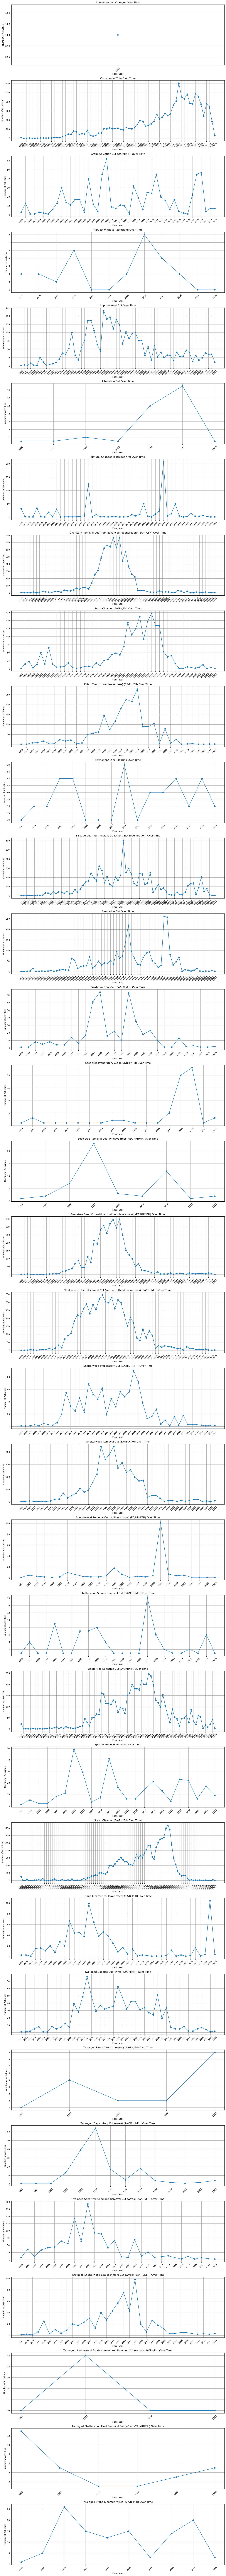

In [69]:
import matplotlib.pyplot as plt

# Create a subplot for each activity type
num_activities = len(activities)
fig, axes = plt.subplots(num_activities, 1, figsize=(15, 5*num_activities))

# Create a dictionary to store year counts for each activity
activity_years = {}

# Collect data
for feature in harvests:
    activity = feature['properties']['ACTIVITY_NAME']
    year = feature['properties']['FY_COMPLETED']
    
    if activity is not None and year is not None:
        if activity not in activity_years:
            activity_years[activity] = {}
        
        activity_years[activity][year] = activity_years[activity].get(year, 0) + 1

# Plot data for each activity
for idx, activity in enumerate(sorted(activity_years.keys())):
    # Get year counts for this activity
    year_counts = activity_years[activity]
    
    # Sort years and get corresponding counts
    sorted_years = sorted(year_counts.keys())
    counts = [year_counts[year] for year in sorted_years]
    
    # Create the plot
    axes[idx].plot(sorted_years, counts, marker='o')
    axes[idx].set_xlabel('Fiscal Year')
    axes[idx].set_ylabel('Number of Activities')
    axes[idx].set_title(f'{activity} Over Time')
    axes[idx].grid(True)
    
    # Rotate x-axis labels for better readability
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()


/var/folders/8h/kk4k5t952ydbc8hfg6nct2940000gn/T/ipykernel_38736/940115780.py:25: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  feature['properties']['harvest_category'] = category


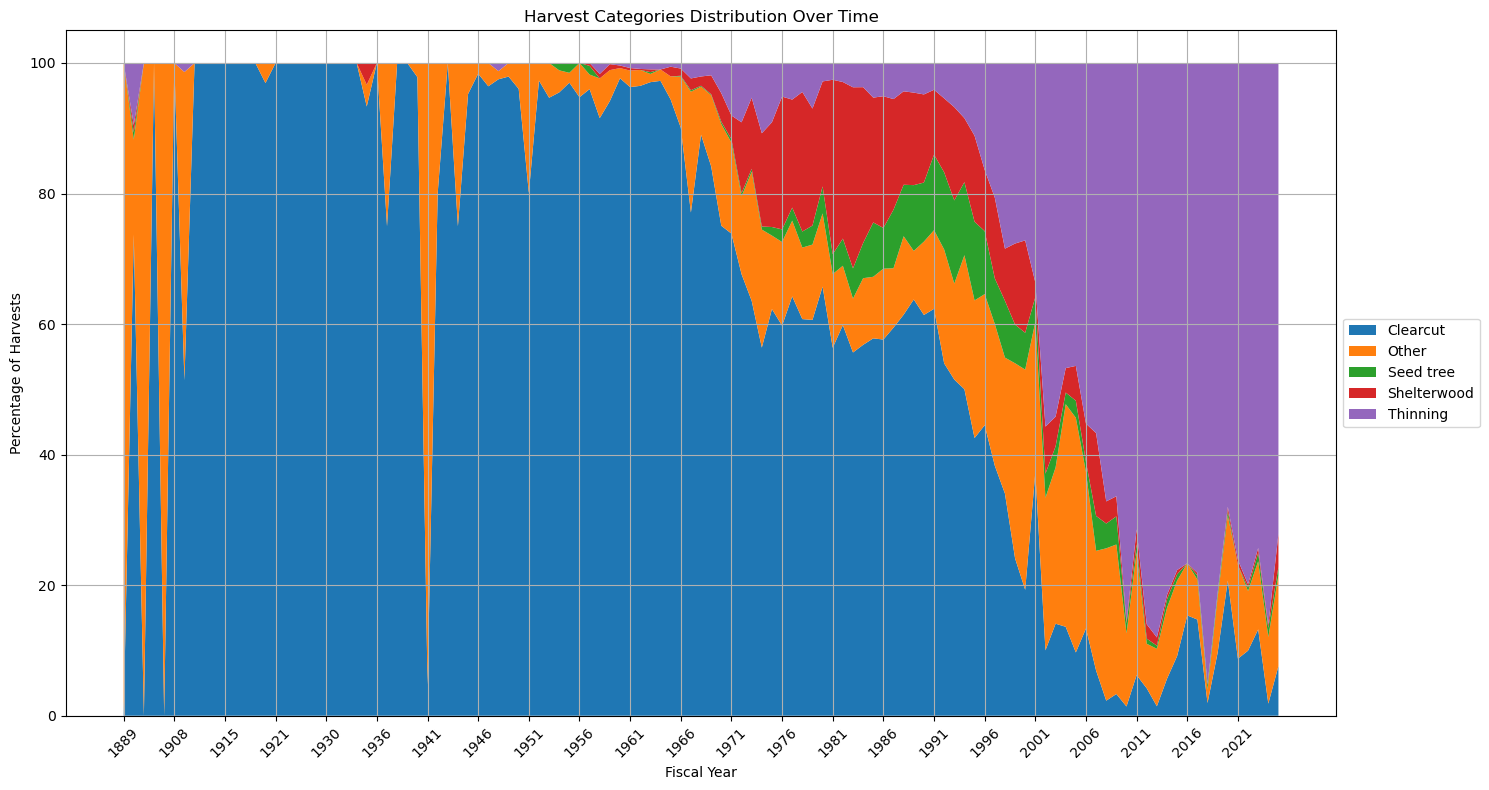

In [72]:

# Create a dictionary to map activities to categories
activity_categories = {}

# Classify each activity
for feature in harvests:
    activity = feature['properties']['ACTIVITY_NAME']
    
    if activity is None:
        category = "Other"
    elif "seed" in activity.lower():
        category = "Seed tree"
    elif "shelterwood" in activity.lower():
        category = "Shelterwood" 
    elif "clearcut" in activity.lower() or "regeneration" in activity.lower():
        category = "Clearcut"
    elif "thin" in activity.lower() or "commercial" in activity.lower():
        category = "Thinning"
    else:
        category = "Other"
        
    # Add to dictionary
    activity_categories[activity] = category
    
    # Add category to feature properties
    feature['properties']['harvest_category'] = category

# Group harvests by year and category
year_category_counts = {}
total_by_year = {}

# First pass - count harvests by year and category
for feature in harvests:
    year = feature['properties']['FY_COMPLETED']
    category = feature['properties']['harvest_category']
    
    if year is not None:
        if year not in year_category_counts:
            year_category_counts[year] = {}
        if year not in total_by_year:
            total_by_year[year] = 0
            
        year_category_counts[year][category] = year_category_counts[year].get(category, 0) + 1
        total_by_year[year] += 1

# Calculate percentages and organize data for plotting
years = sorted(year_category_counts.keys())
categories = sorted(set(activity_categories.values()))

# Create percentage arrays for each category
category_percentages = {cat: [] for cat in categories}

for year in years:
    for category in categories:
        count = year_category_counts[year].get(category, 0)
        percentage = (count / total_by_year[year]) * 100
        category_percentages[category].append(percentage)
# Create the stacked area plot
plt.figure(figsize=(15, 8))
plt.stackplot(years, 
             [category_percentages[cat] for cat in categories],
             labels=categories)

plt.xlabel('Fiscal Year')
plt.ylabel('Percentage of Harvests')
plt.title('Harvest Categories Distribution Over Time')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

# Show year labels every 5 years
plt.xticks(years[::5], years[::5], rotation=45)
plt.tight_layout()




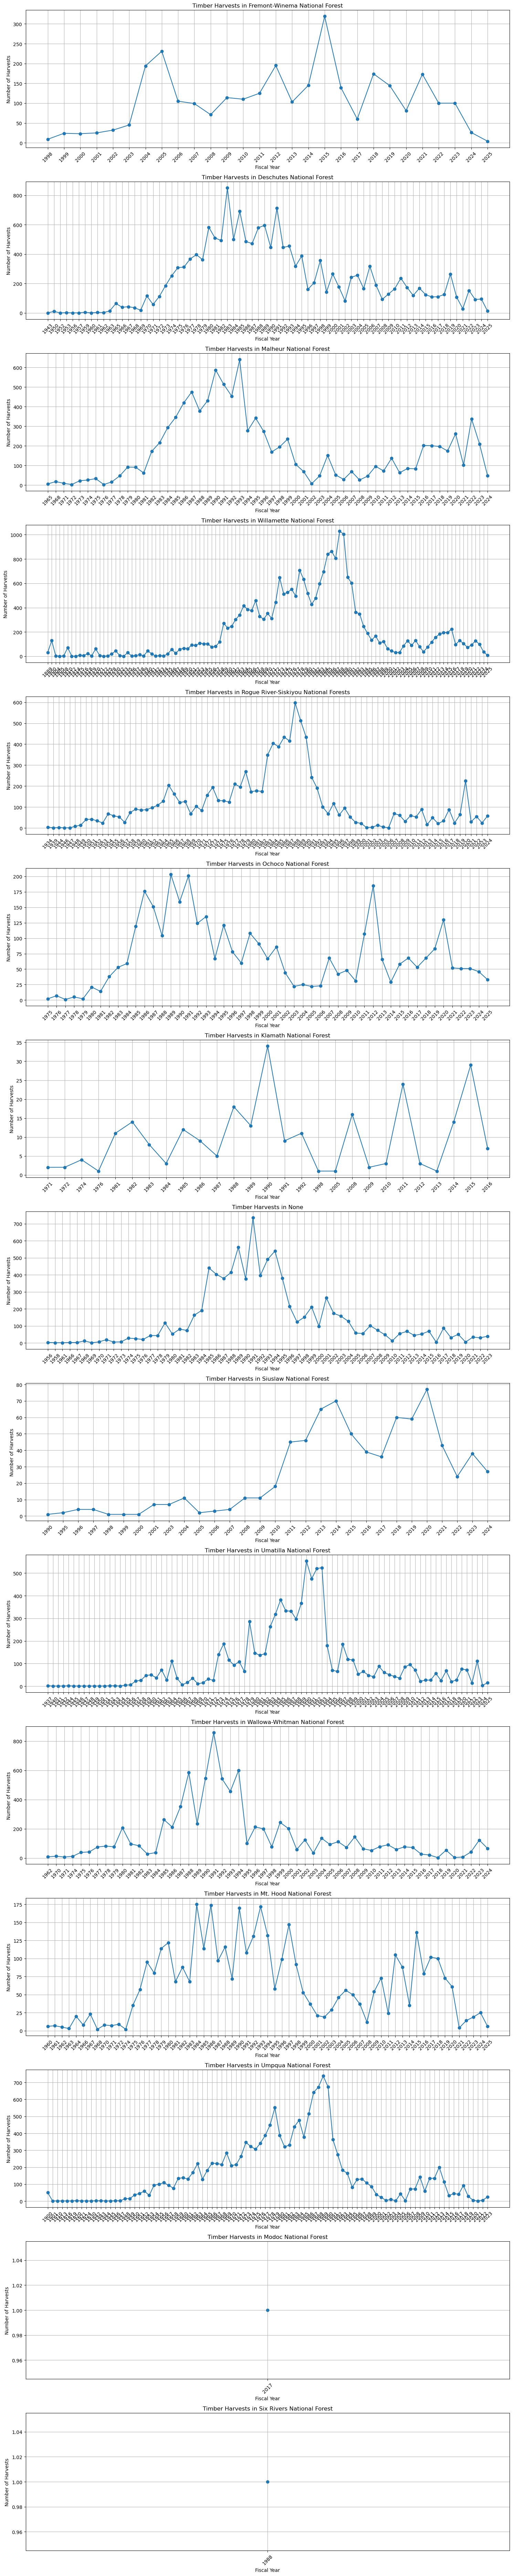

In [66]:
import matplotlib.pyplot as plt

# Create a subplot for each forest
num_forests = len(grouped_harvests)
fig, axes = plt.subplots(num_forests, 1, figsize=(15, 5*num_forests))

for idx, (forest_name, features) in enumerate(grouped_harvests.items()):
    
    
    # Extract year values for this forest
    years = [f['properties']['FY_COMPLETED'] for f in features]
    
    # Count occurrences of each year
    year_counts = {}
    for year in years:
        if year is not None:
            year_counts[year] = year_counts.get(year, 0) + 1
        
    # Sort by year for plotting
    sorted_years = sorted(year_counts.keys())
    counts = [year_counts[year] for year in sorted_years]
    
    # Plot line for this forest in its own subplot
    axes[idx].plot(sorted_years, counts, marker='o')
    axes[idx].set_xlabel('Fiscal Year')
    axes[idx].set_ylabel('Number of Harvests')
    axes[idx].set_title(f'Timber Harvests in {forest_name}')
    axes[idx].grid(True)
    
    # Rotate x-axis labels for better readability
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()



In [2]:
import pandas as pd

df = pd.read_csv('sources/oregon_timber_harvests.csv')

df.head()


Year  Private  Native American  State  BLM / Other Public  USFS  \
0  1849      NaN              NaN    NaN                 NaN   NaN   
1  1859      NaN              NaN    NaN                 NaN   NaN   
2  1869      NaN              NaN    NaN                 NaN   NaN   
3  1879      NaN              NaN    NaN                 NaN   NaN   
4  1889      NaN              NaN    NaN                 NaN   NaN   

   Private and State Combined  Total  
0                         NaN   17.0  
1                         NaN   41.0  
2                         NaN   75.0  
3                         NaN  177.0  
4                         NaN  463.0

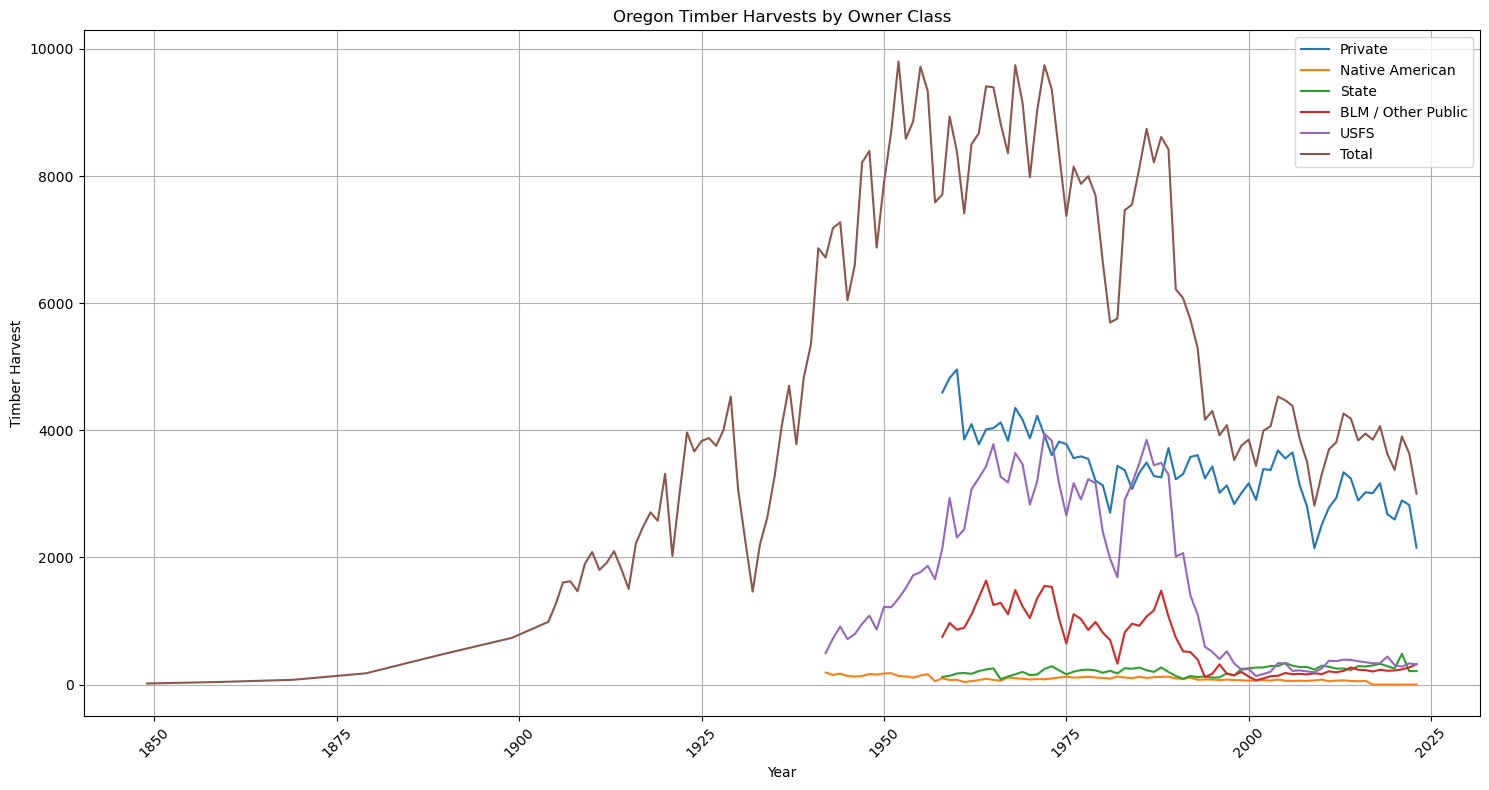

In [12]:
from matplotlib import pyplot as plt

# Create line plot
plt.figure(figsize=(15, 8))

# Plot each column except Year
for column in df.columns:
    if column != 'Year' and column != "Private and State Combined":
        plt.plot(df['Year'], df[column], label=column)

plt.xlabel('Year')
plt.ylabel('Timber Harvest')
plt.title('Oregon Timber Harvests by Owner Class')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig('sources/oregon_timber_harvests_by_owner_class.svg')



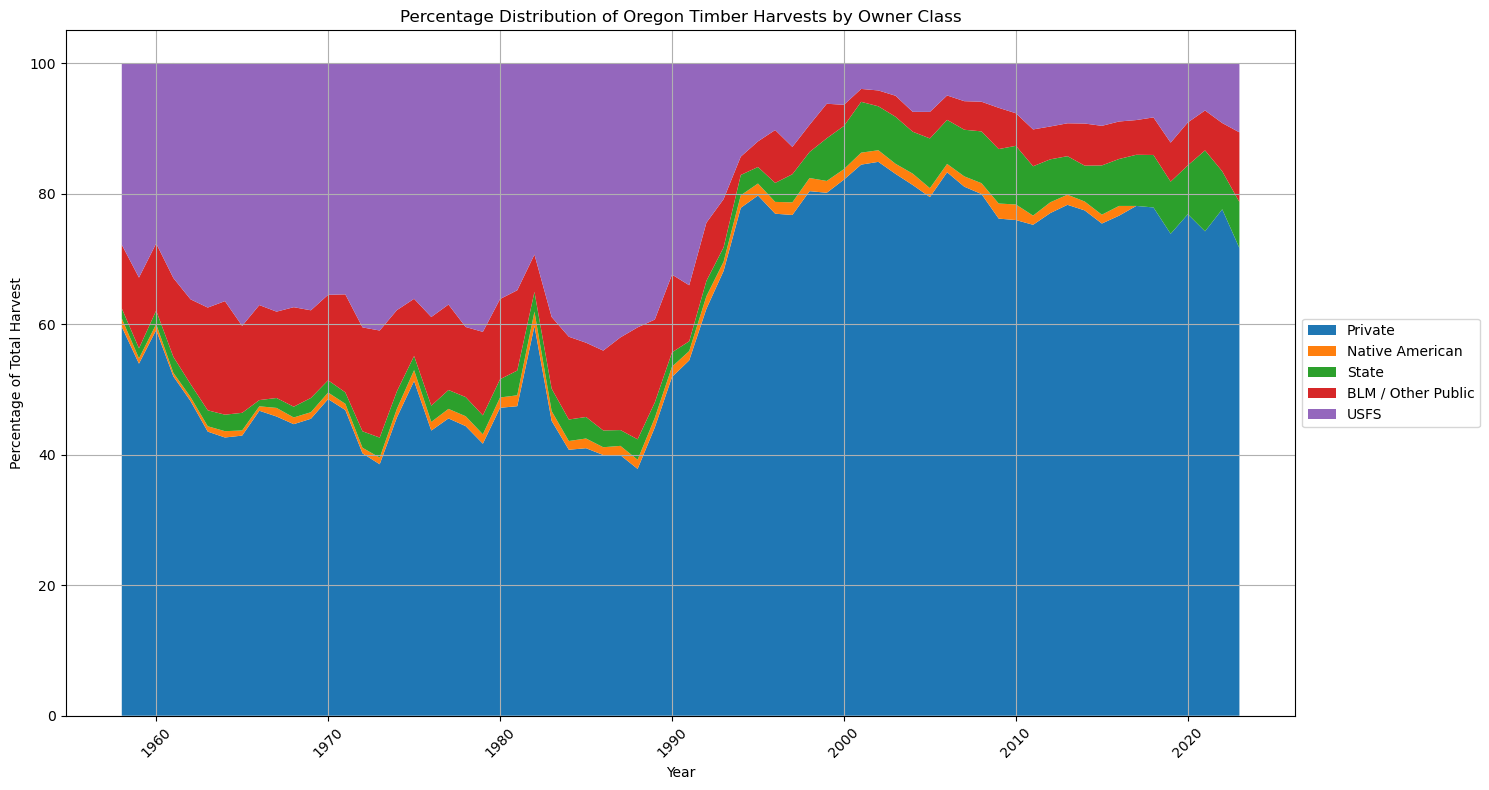

In [4]:
# Calculate percentages
df_pct = df.copy()
for column in df.columns:
    if column != 'Year' and column != "Private and State Combined":
        df_pct[column] = (df[column] / df['Total']) * 100

# Create percentage stacked area plot
plt.figure(figsize=(15, 8))

# Plot stacked areas
columns_to_plot = [col for col in df_pct.columns if col not in ['Year', 'Total', 'Private and State Combined']]
plt.stackplot(df_pct['Year'], 
             [df_pct[col] for col in columns_to_plot],
             labels=columns_to_plot)

plt.xlabel('Year')
plt.ylabel('Percentage of Total Harvest')
plt.title('Percentage Distribution of Oregon Timber Harvests by Owner Class')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()

# save as svg
plt.savefig('sources/oregon_timber_harvests_by_owner_class.svg')



In [ ]:
def gaussian_smooth(x, y, sd):
    weights = np.array([stats.norm.pdf(x, m, sd) for m in x])
    weights = weights / weights.sum(1)
    return (weights * y).sum(1)

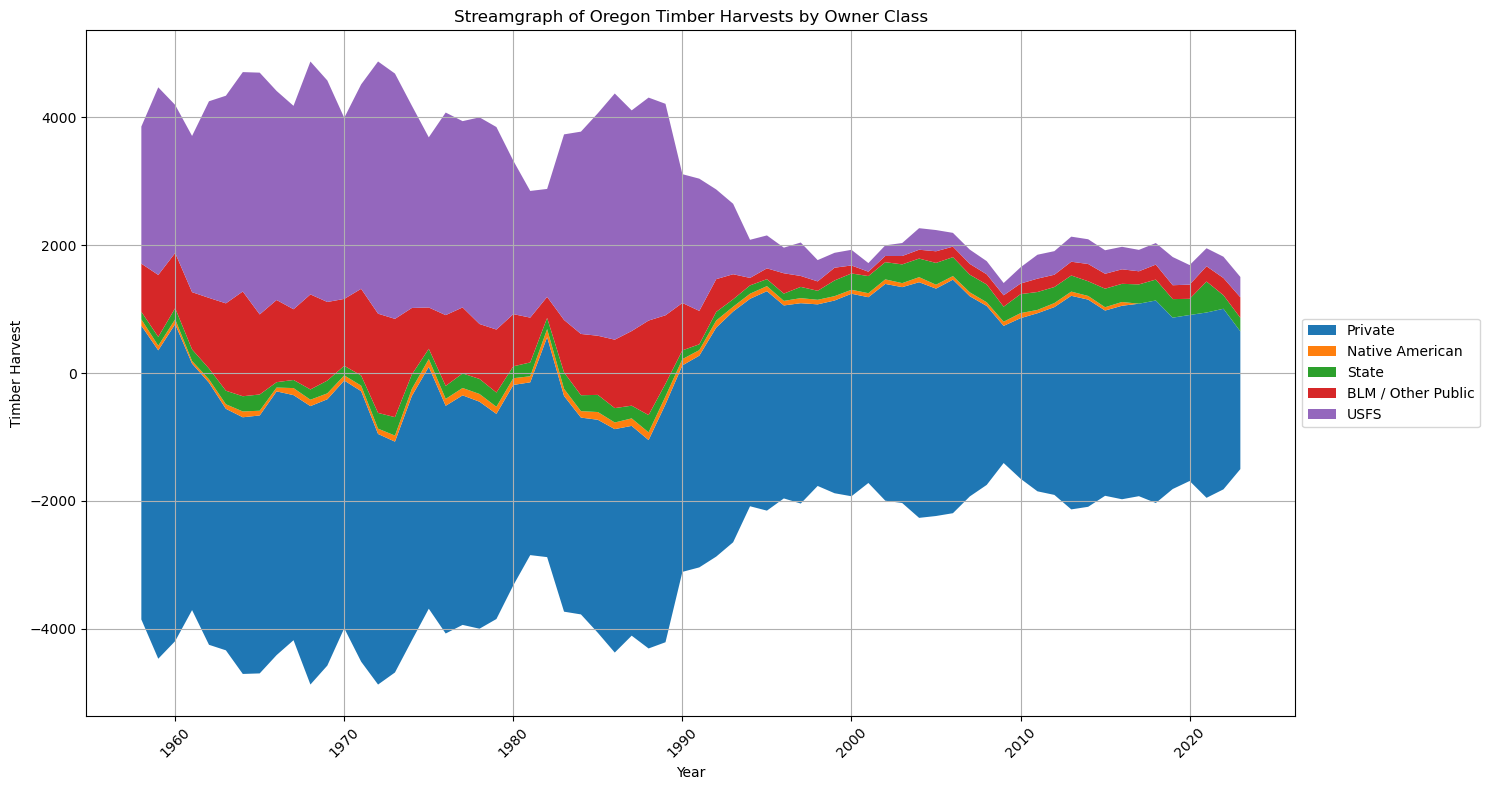

In [11]:
# Create streamgraph
plt.figure(figsize=(15, 8))

# Plot streamgraph using stackplot with baseline='wiggle'
columns_to_plot = [col for col in df.columns if col not in ['Year', 'Total', 'Private and State Combined']]
plt.stackplot(df['Year'], 
             [df[col] for col in columns_to_plot],
             labels=columns_to_plot,
             baseline='sym')  # This makes it a streamgraph

plt.xlabel('Year')
plt.ylabel('Timber Harvest')
plt.title('Streamgraph of Oregon Timber Harvests by Owner Class')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()

# save as svg
plt.savefig('sources/oregon_timber_harvests_streamgraph.svg')


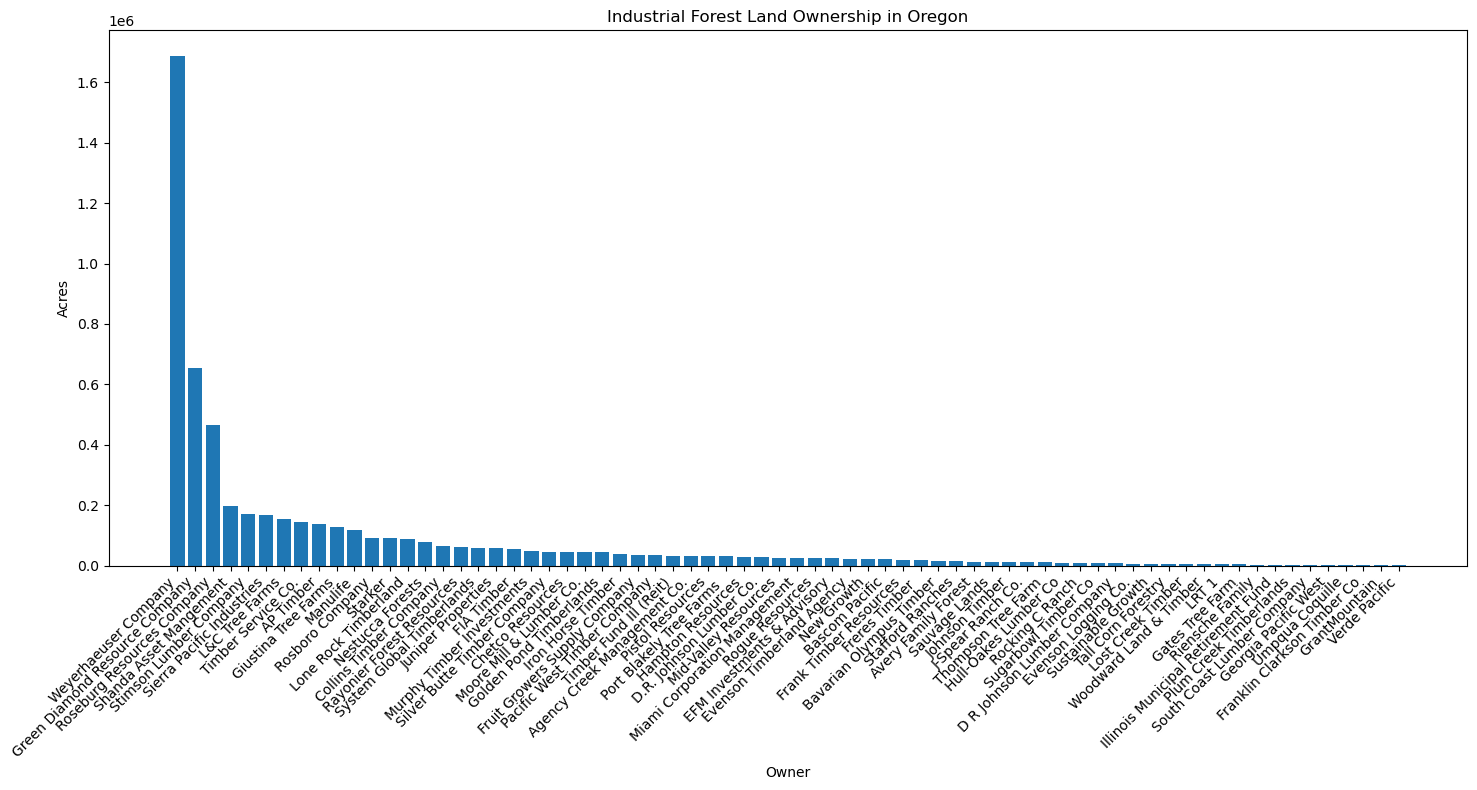

In [34]:
import json
# Load private ownership data
with open('summary/private-ownership.json', 'r') as f:
    private_ownership = json.load(f)

# Create bar chart
plt.figure(figsize=(15, 8))

owners = []
acres = []
for owner in private_ownership['industrial_owners']:
    if owner['owner'] is not None:
        owners.append(owner['owner'])
        acres.append(owner['acres'])

plt.bar(owners, acres)
plt.xlabel('Owner')
plt.ylabel('Acres')
plt.title('Industrial Forest Land Ownership in Oregon')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

# Save as svg
plt.savefig('sources/oregon_industrial_forest_ownership.svg')


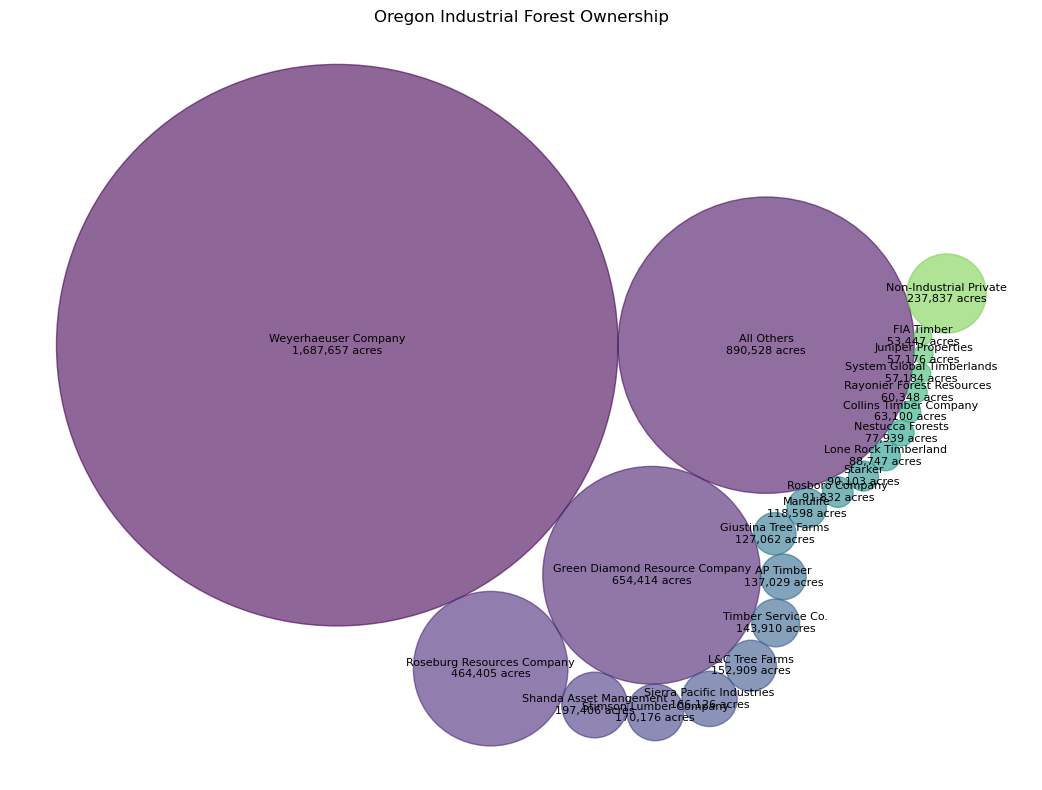

In [39]:
import packcircles
import numpy as np


# Add to owners and acres lists
owners.append('Non-Industrial Private')
acres.append(private_ownership['total_non_industrial_acres'])


# Combine owners with less than 50k acres into 'all others'
small_owners_acres = 0
filtered_owners = []
filtered_acres = []

for owner, acre in zip(owners, acres):
    if acre < 50000:
        small_owners_acres += acre
    else:
        filtered_owners.append(owner)
        filtered_acres.append(acre)

if small_owners_acres > 0:
    filtered_owners.append('All Others')
    filtered_acres.append(small_owners_acres)

owners = filtered_owners
acres = filtered_acres

# Create packed circle layout
plt.figure(figsize=(15, 8))

# Generate circle positions and sizes
# Scale the acres to reasonable circle sizes relative to figure size
scaled_acres = [a / max(acres) * 4 for a in acres]  # Scale to max radius of 4 units
circles = packcircles.pack(scaled_acres)
circles = list(circles)

# Plot circles
colors = plt.cm.viridis(np.linspace(0, 0.8, len(circles)))
for (x, y, r), owner, color in zip(circles, owners, colors):
    circle = plt.Circle((x, y), r, alpha=0.6, color=color)
    plt.gca().add_patch(circle)
    
    # Add labels
    plt.text(x, y,
             f'{owner}\n{int(acres[owners.index(owner)]):,} acres',
             ha='center',
             va='center',
             fontsize=8)

plt.title('Oregon Industrial Forest Ownership')

# Set equal aspect ratio and remove axes
plt.gca().set_aspect('equal')
plt.axis('off')

# Adjust plot limits to show all circles
plt.autoscale()
plt.tight_layout()

# Save as svg   
plt.savefig('sources/oregon_industrial_forest_ownership_circles.svg')